<center><h1>Thai_Khang_HW1</h1></center>
<br>
<center><font size="4">Vertebral Column Data</font></center>

Name: Khang Thai

GitHub Username: kunfupen

USC ID: 5721113147

### (a) Download Data

Package imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score
from math import floor


Get the Vertebral Column Data Set

In [4]:
data, meta = arff.loadarff('vertebral_column_data/column_2C_weka.arff')
vertebral_data = pd.DataFrame(data)


if vertebral_data['class'].dtype == object:
    vertebral_data['class'] = vertebral_data['class'].apply(
        lambda x: x.decode('utf-8') if isinstance(x, bytes) else x
    )
 
label_map = {'Abnormal': 1, 'Normal': 0}
vertebral_data['Class01'] = vertebral_data['class'].map(label_map).astype(int)


cols = [
    "pelvic_incidence",
    "pelvic_tilt",
    "lumbar_lordosis_angle",
    "sacral_slope",
    "pelvic_radius",
    "degree_spondylolisthesis",
]

vertebral_data.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class,Class01
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal,1


### (b) Pre-Processing and Exploratory Data Analysis

#### i. Scatterplots

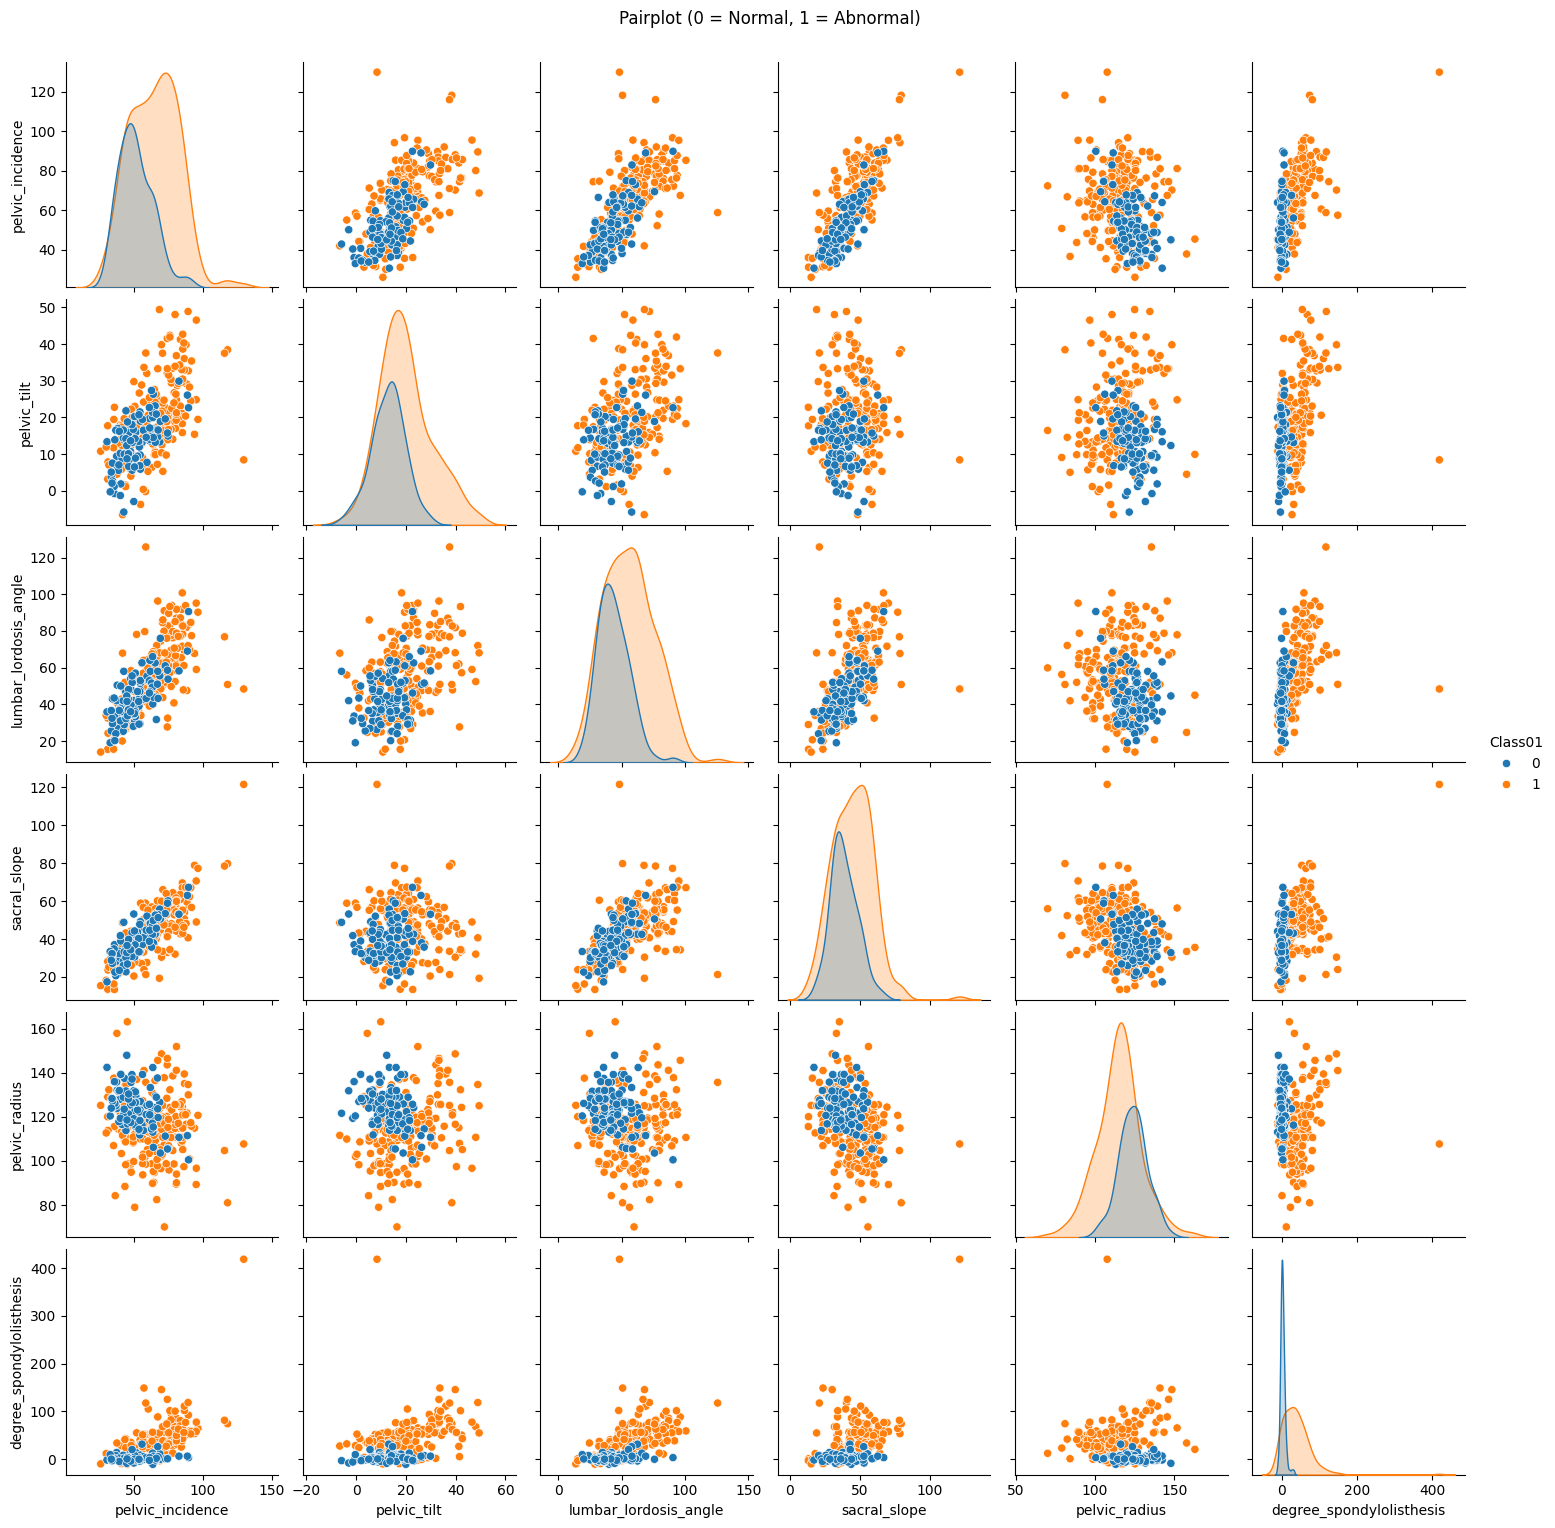

In [5]:
scat = sns.pairplot(data = vertebral_data, vars = cols, hue = 'Class01')
scat.fig.suptitle("Pairplot (0 = Normal, 1 = Abnormal)", y=1.02)
plt.show()

#### ii. Boxplots

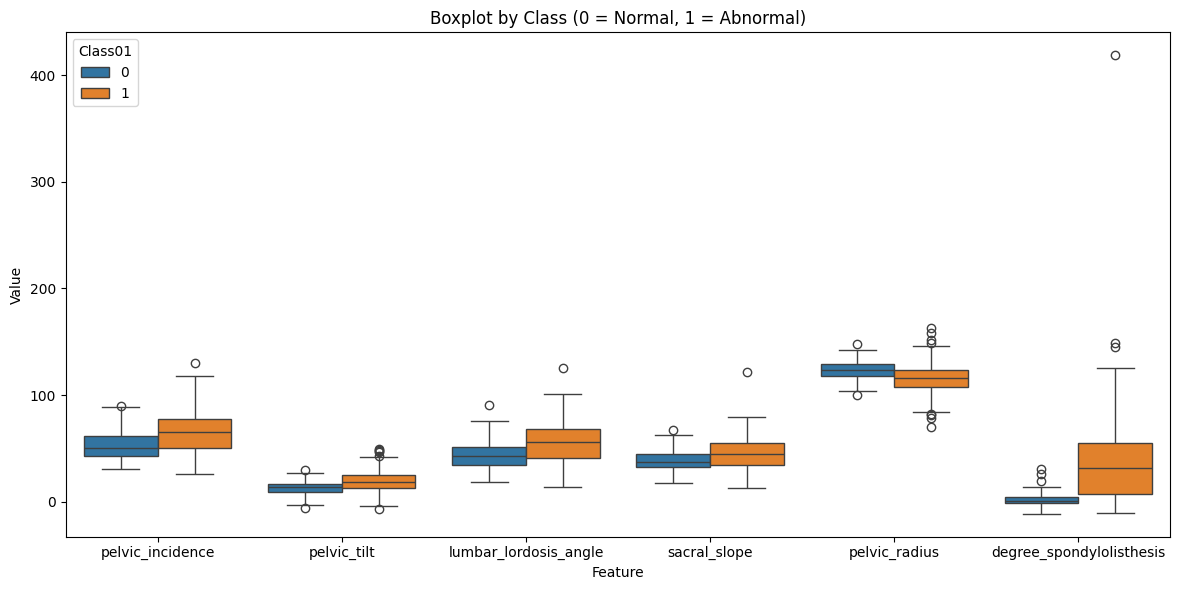

In [6]:
plt.figure(figsize=(12, 6))
bp = sns.boxplot(data = vertebral_data.melt(
    id_vars='Class01', value_vars=cols, var_name='Feature', value_name='Value'),
      hue='Class01', 
      x= 'Feature', 
      y= 'Value')
bp.set_title("Boxplot by Class (0 = Normal, 1 = Abnormal)")
plt.tight_layout()
plt.show()

#### iii. Split Data Set

In [7]:
class0 = vertebral_data[vertebral_data['Class01'] == 0]
class1 = vertebral_data[vertebral_data['Class01'] == 1]

train_df = pd.concat([class0.iloc[:70], class1.iloc[:140]], axis=0)
test_df = pd.concat([class0.iloc[70:], class1.iloc[140:]], axis=0)

x_train = train_df[cols].values
y_train = train_df['Class01'].values
x_test = test_df[cols].values
y_test = test_df['Class01'].values


### (c) Classification

#### i. Euclidean Metric

In [8]:
scaler = StandardScaler()
x_train_s = scaler.fit_transform(x_train)

knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(x_train_s, y_train)

y_train_pred = knn.predict(x_train_s)

accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {accuracy:.4f}")

Training accuracy: 0.8714


#### ii. Test Data

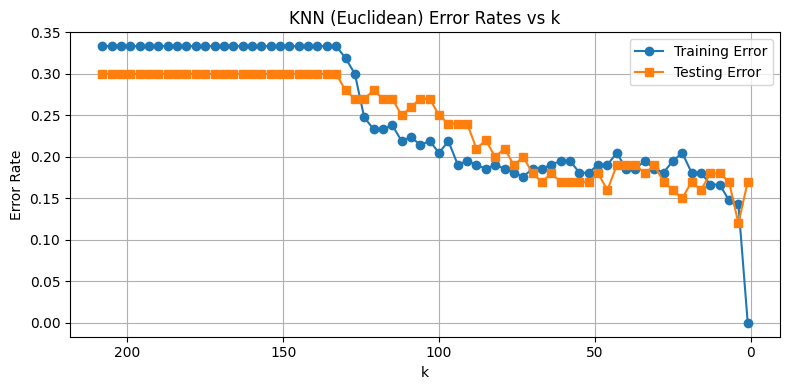

k* = 4 
test error = 0.1200 
train error = 0.1429
Confusion Matrix:
[[22  8]
 [ 4 66]]
True Positive Rate (TPR): 0.9429
True Negative Rate (TNR): 0.7333
Precision: 0.8919
F1 Score: 0.9167


In [9]:
n_train = x_train_s.shape[0]
k_values = [k for k in range(208, 0, -3) if k <= n_train]

train_err = []
test_err = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(x_train_s, y_train)
    
    y_train_pred = knn.predict(x_train_s)
    y_test_pred = knn.predict(scaler.transform(x_test))
    
    train_err.append(1 - accuracy_score(y_train, y_train_pred))
    test_err.append(1 - accuracy_score(y_test, y_test_pred))

plt.figure(figsize=(8,4))
plt.plot(k_values, train_err, label='Training Error', marker='o')
plt.plot(k_values, test_err, label='Testing Error', marker='s')
plt.gca().invert_xaxis()
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('KNN (Euclidean) Error Rates vs k')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

test_err = np.array(test_err)
best_idx = int(np.argmin(test_err))
k_star = k_values[best_idx]
print(f"k* = {k_star} \ntest error = {test_err[best_idx]:.4f} \ntrain error = {train_err[best_idx]:.4f}")

knn_star = KNeighborsClassifier(n_neighbors=k_star, metric='euclidean')
knn_star.fit(x_train_s, y_train)
y_pred = knn_star.predict(scaler.transform(x_test))

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print("Confusion Matrix:")
print(cm)
TN, FP, FN, TP = cm.ravel()
tpr = TP / (TP + FN) if (TP + FN) else 0
print(f"True Positive Rate (TPR): {tpr:.4f}")
tnr = TN / (TN + FP) if (TN + FP) else 0
print(f"True Negative Rate (TNR): {tnr:.4f}")
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

#### iii. Learning Curve

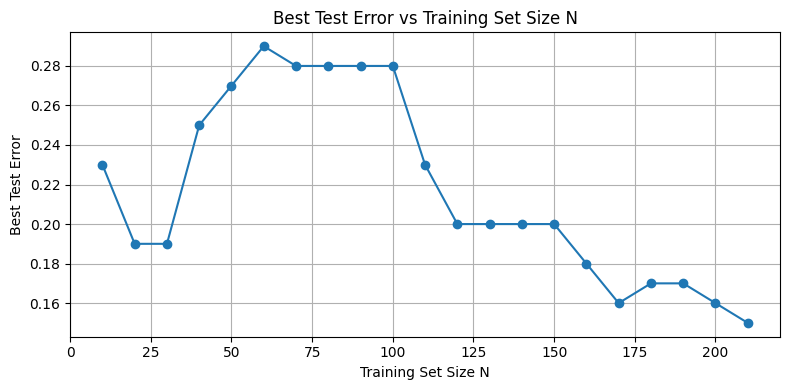

Best k values for each N:
{10: 1, 20: 6, 30: 1, 40: 11, 50: 11, 60: 16, 70: 26, 80: 21, 90: 36, 100: 36, 110: 6, 120: 6, 130: 6, 140: 16, 150: 1, 160: 6, 170: 6, 180: 1, 190: 1, 200: 16, 210: 26}


In [10]:
train_0 = train_df[train_df['Class01'] == 0].reset_index(drop=True)
train_1 = train_df[train_df['Class01'] == 1].reset_index(drop=True)

Ns = list(range(10, 211, 10))
best_errors = []
best_ks = []

for N in Ns:
    n0 = floor(N / 3)
    n1 = N - n0

    if n0 > len(train_0) or n1 > len(train_1):
        best_errors.append(np.nan)
        best_ks.append(None)
        continue

    sub_df = pd.concat([train_0.iloc[:n0], train_1.iloc[:n1]], axis=0)
    x_sub = sub_df[cols].values
    y_sub = sub_df['Class01'].values

    scaler_N = StandardScaler()
    x_sub_s = scaler_N.fit_transform(x_sub)
    n_test_sN = scaler_N.transform(x_test)

    k_candidates = [k for k in range(1, N + 1, 5) if k <= len(x_sub_s)]
    te_errors = []

    for k in k_candidates:
        knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        knn.fit(x_sub_s, y_sub)
        y_te_pred = knn.predict(n_test_sN)
        te_errors.append(1 - accuracy_score(y_test, y_te_pred))
    
    min_err = min(te_errors)
    ks_with_min = [k for k, e in zip(k_candidates, te_errors) if abs(e - min_err) < 1e-12]
    k_best = min(ks_with_min)

    best_errors.append(min_err)
    best_ks.append(k_best)

plt.figure(figsize=(8,4))
plt.plot(Ns, best_errors, marker='o')
plt.xlabel('Training Set Size N')
plt.ylabel('Best Test Error')
plt.title('Best Test Error vs Training Set Size N')
plt.tight_layout()
plt.grid()
plt.show()

print("Best k values for each N:")
print(dict(zip(Ns, best_ks)))


### (d) Other Metrics

#### i. Minkowski Distance.

##### A. Manhattan Distance with p = 1.

In [11]:
x_test_s = scaler.transform(x_test)

k_candidates = [k for k in range(1, 197, 5) if k <= x_train_s.shape[0]]

test_errors = []
for k in k_candidates:
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn.fit(x_train_s, y_train)
    y_te = knn.predict(x_test_s)
    test_errors.append(1 - accuracy_score(y_test, y_te))

min_err = min(test_errors)
k_star_A = min(k for k, e in zip(k_candidates, test_errors) if abs(e - min_err) < 1e-12)

knn_A = KNeighborsClassifier(n_neighbors=k_star_A, metric='manhattan')
knn_A.fit(x_train_s, y_train)
y_pred = knn_A.predict(x_test_s)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
TN, FP, FN, TP = cm.ravel()
tpr = TP / (TP + FN) if (TP + FN) else 0
tnr = TN / (TN + FP) if (TN + FP) else 0
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nManhattan Distance Metric Results (k* = {k_star_A}):")
print(f"Test error: {min_err:.4f}")
print(f"Test accuracy: {acc:.4f}")
print(f"confusion matrix:\n{cm}")
print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"True Negative Rate (TNR): {tnr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")


Manhattan Distance Metric Results (k* = 6):
Test error: 0.1400
Test accuracy: 0.8600
confusion matrix:
[[21  9]
 [ 5 65]]
True Positive Rate (TPR): 0.9286
True Negative Rate (TNR): 0.7000
Precision: 0.8784
F1 Score: 0.9028


##### B. With log10(p) in {0.1, 0.2, 0.3, ... ,1}.

In [12]:
log10_ps = [round(g, 1) for g in np.arange(0.1, 1 + 1e-9, 0.1)]
p_values = [10**g for g in log10_ps]

res_B = []
for g, p in zip(log10_ps, p_values):
    knn_B = KNeighborsClassifier(n_neighbors = k_star_A, metric = 'minkowski', p = p)
    knn_B.fit(x_train_s, y_train)
    te_err = 1 - accuracy_score(y_test, knn_B.predict(x_test_s))
    res_B.append((g, p, te_err))

best_g, best_p, best_err = min(res_B, key=lambda t: (t[2], t[0]))
print(f"Best log10(p): {best_g:.4f}")
print(f"p: {best_p:.4f}")
print(f"Test error: {best_err:.4f}")
print(f"Test accuracy: {1 - best_err:.4f}")


Best log10(p): 0.4000
p: 2.5119
Test error: 0.1600
Test accuracy: 0.8400


##### C. Chebyshev Distance With p -> infinity.

In [13]:
k_candidates = [k for k in range(1, 197, 5) if k <= x_train_s.shape[0]]

test_errors = []
for k in k_candidates:
    knn_C = KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
    knn_C.fit(x_train_s, y_train)
    y_te = knn_C.predict(x_test_s)
    test_errors.append(1 - accuracy_score(y_test, y_te))

min_err = min(test_errors)
k_star_C = min(k for k, e in zip(k_candidates, test_errors) if abs(e - min_err) < 1e-12)

knn_C = KNeighborsClassifier(n_neighbors=k_star_C, metric='chebyshev')
knn_C.fit(x_train_s, y_train)
y_pred = knn_C.predict(x_test_s)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
TN, FP, FN, TP = cm.ravel()
tpr = TP / (TP + FN) if (TP + FN) else 0
tnr = TN / (TN + FP) if (TN + FP) else 0
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nChebyshev Distance Metric Results (k* = {k_star_C}):")
print(f"Test error: {min_err:.4f}")
print(f"Test accuracy: {acc:.4f}")
print(f"confusion matrix:\n{cm}")
print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"True Negative Rate (TNR): {tnr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4}")




Chebyshev Distance Metric Results (k* = 1):
Test error: 0.1500
Test accuracy: 0.8500
confusion matrix:
[[19 11]
 [ 4 66]]
True Positive Rate (TPR): 0.9429
True Negative Rate (TNR): 0.6333
Precision: 0.8571
F1 Score: 0.898


#### ii. Mahalanobis Distance.

In [14]:
cov = np.cov(x_train_s, rowvar=False)
VI = np.linalg.pinv(cov)
k_candidates = [k for k in range(1, 197, 5) if k <= x_train_s.shape[0]]

test_errors = []
for k in k_candidates:
    knn_M = KNeighborsClassifier(n_neighbors=k, metric='mahalanobis', metric_params={'VI': VI}, algorithm='brute')
    knn_M.fit(x_train_s, y_train)
    y_te = knn_M.predict(x_test_s)
    test_errors.append(1 - accuracy_score(y_test, y_te))

min_err_M = min(test_errors)
k_star_M = min(k for k, e in zip(k_candidates, test_errors) if abs(e - min_err_M) < 1e-12)

knn_M = KNeighborsClassifier(n_neighbors=k_star_M, metric='mahalanobis', metric_params={'VI': VI}, algorithm='brute')
knn_M.fit(x_train_s, y_train)
y_pred = knn_M.predict(x_test_s)

acc_M = accuracy_score(y_test, y_pred)
cm_M = confusion_matrix(y_test, y_pred, labels=[0, 1])
TN, FP, FN, TP = cm_M.ravel()
tpr_M = TP / (TP + FN) if (TP + FN) else 0   
tnr_M = TN / (TN + FP) if (TN + FP) else 0
precision_M = precision_score(y_test, y_pred)
f1_M = f1_score(y_test, y_pred)

print(f"Mahalanobis Distance Metric Results (k* = {k_star_M}):")
print(f"Test error: {min_err_M:.4f}")
print(f"Test accuracy: {acc_M:.4f}")
print(f"confusion matrix:\n{cm_M}")
print(f"True Positive Rate (TPR): {tpr_M:.4f}")
print(f"True Negative Rate (TNR): {tnr_M:.4f}")
print(f"Precision: {precision_M:.4f}")
print(f"F1 Score: {f1_M:.4}")

Mahalanobis Distance Metric Results (k* = 1):
Test error: 0.1500
Test accuracy: 0.8500
confusion matrix:
[[19 11]
 [ 4 66]]
True Positive Rate (TPR): 0.9429
True Negative Rate (TNR): 0.6333
Precision: 0.8571
F1 Score: 0.898


### (e) Weighted Decision

In [17]:
k_candidates = [k for k in range(1, 197, 5) if k <= x_train_s.shape[0]]
metrics = [
    ('euclidean', 'Euclidean'),
    ('manhattan', 'Manhattan'),
    ('chebyshev', 'Chebyshev'),
]

sum_rows = []
weighted_train_err = []

for metric_key, metric_name in metrics:
    te_err = []
    tr_err = []
    for k in k_candidates:
        knn = KNeighborsClassifier(n_neighbors=k, metric = metric_key, weights = 'distance')
        knn.fit(x_train_s, y_train)
        y_tr = knn.predict(x_train_s)
        y_te = knn.predict(x_test_s)
        tr_err.append(1 - accuracy_score(y_train, y_tr))
        te_err.append(1 - accuracy_score(y_test, y_te))
    
    te_err = np.array(te_err)
    tr_err = np.array(tr_err)
    best_idx = int(np.argmin(te_err))
    k_star_w = k_candidates[best_idx]

    sum_rows.append({
        "Metrics": metric_name,
        "Weights": "distance",
        "k*": k_star_w,
        "Test Error": round(float(te_err[best_idx]), 4),
        "Test Accuracy": round(float(1 - te_err[best_idx]), 4),
        "Train Error k*": round(float(tr_err[best_idx]), 4),
        "Min Train Error": round(float(tr_err.min()), 4)
    })

    weighted_train_err.append(tr_err.min())

sum_df = pd.DataFrame(sum_rows)
display(sum_df)

lowest_train_err = float(np.min(weighted_train_err))
min_train_err = lowest_train_err

print(lowest_train_err)
print(min_train_err)

,Metrics,Weights,k*,Test Error,Test Accuracy,Train Error k*,Min Train Error
0,Euclidean,distance,21,0.15,0.85,0.0,0.0
1,Manhattan,distance,6,0.15,0.85,0.0,0.0
2,Chebyshev,distance,1,0.15,0.85,0.0,0.0


0.0
0.0


### (f) Training Error Rate

0.0